In [1]:
import sqlite3
import random
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

В эксперименте информантам показываются слова, и они должны определить, является ли слово словом из русского языка, или оно придуманное.

Получается есть ответы [слово, не слово] и время реакции.

Про информантов есть мета-информация - возраст, пол, город рождения, последняя ступень образования.

Структура базы данных:
* participants: id_part, age, sex, city, edu
* words: id_word, word, is_word
* answers: id_ans, id_word, id_part, is_word, time


Я считаю, что имена информантов брать не надо, достаточно их id

### Создаем таблицы в базе данных

In [3]:
con = sqlite3.connect('experiment.db')
c = con.cursor()

In [59]:
c.execute(f"""
           CREATE TABLE IF NOT EXISTS
           participants(id_part integer,
                        age integer,
                        sex text,
                        city text,
                        edu text)""")

c.execute(f"""
           CREATE TABLE IF NOT EXISTS
           words(id_word integer,
                        word text,
                        is_word integer)""")

c.execute(f"""
           CREATE TABLE IF NOT EXISTS
           answers(id_ans integer,
                   id_word integer,
                   id_part integer,
                   is_word integer,
                   time integer)""")

### Генерируем информациюи загружаем в базу данных.

In [23]:
words = [('собака',1),('субака',0),('цент',1),('парашут',1),('кокукола',0)]
sexes = ['f','m']
cities = ['Москва','СПб','Тюмень','Грозный','Казань','Красноярск','Краснодар','Уфа','Севастополь','Владивосток','Новосибирск']
edus = ['высшее','среднее общее','среднее профессиональное']

In [24]:
participants = []
for i in range(100):
    age = random.randint(18,80)
    sex = random.choice(sexes)
    city = random.choice(cities)
    edu = random.choice(edus)
    participants.append((i,age,sex,city,edu))

c.executemany(f"INSERT INTO participants VALUES (?, ?, ?, ?, ?)", participants)

In [25]:
words = [(i, word, is_word) for i, (word, is_word) in enumerate(words)]

c.executemany(f"INSERT INTO words VALUES (?, ?, ?)", words)

In [26]:
import itertools

In [27]:
answers = []
for id_answer, (id_word, id_part) in enumerate(itertools.product(range(len(words)),range(len(participants)))):
    is_word = random.randint(0,1)
    time = random.randint(20,400)
    answers.append((id_answer, id_word, id_part, is_word, time))

c.executemany(f"INSERT INTO answers VALUES (?, ?, ?, ?, ?)", answers) 

### Делаем запросы

Хочу посмотреть сколько участников из Москвы

In [61]:
moscow = c.execute(
    '''SELECT * FROM participants WHERE city = 'Москва';'''
)
print(len(list(moscow)), 'people from Moscow')

8 people from Moscow


Хочу посмотреть среднее время реакции для жителей разных городов

In [75]:
city_answers = c.execute(
    '''SELECT avg(time) as avg_time, participants.city FROM answers
    JOIN participants ON answers.id_part = participants.id_part
    GROUP BY participants.city
    ORDER BY avg_time;'''
)

for time, city in city_answers:
    print('Average answer time for', city, 'is {:.2f}'.format(time))

Average answer time for Владивосток is 193.33
Average answer time for Севастополь is 199.36
Average answer time for Грозный is 200.88
Average answer time for Краснодар is 205.29
Average answer time for Новосибирск is 205.76
Average answer time for Уфа is 209.65
Average answer time for Москва is 209.80
Average answer time for Тюмень is 212.43
Average answer time for Красноярск is 225.47
Average answer time for СПб is 226.00
Average answer time for Казань is 247.31


Обновляю образование у людей моложе 22

In [74]:
c.execute(
    '''UPDATE participants SET edu = 'высшее не законченное'
    WHERE age < 22;'''
)

In [110]:
con.commit()

Выгружаю ответы на первый вопрос и группирую их по полу участника

In [105]:
sex_answers = c.execute(
    '''SELECT words.id_word, answers.time, participants.sex
    FROM answers JOIN participants ON participants.id_part = answers.id_part
    JOIN words ON words.id_word = answers.id_word
    WHERE words.id_word == 0;
    '''
)

In [106]:
sex_answers = list(sex_answers)
sex_answers = {'time':[answer[1] for answer in sex_answers],
              'sex':[answer[2] for answer in sex_answers]}

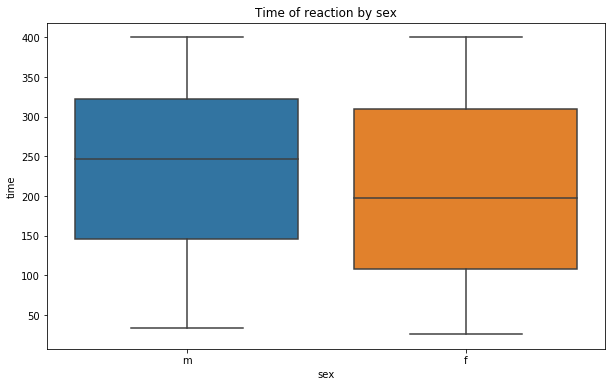

In [109]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="sex", y="time", data=sex_answers)
plt.title('Time of reaction by sex')
plt.ylabel('time')
plt.xlabel('sex');

In [111]:
con.close()